# DGEB Final Project Notebook: Traditional Models for Convergent Enzyme Classification

## Authors: Mahbuba Tasmin & Bryn Reimer  
Course: CS 690U — Spring 2025  
Date: April 2025

## Objective

We aim to benchmark the performance of the following traditional approaches:
- **Logistic regression** trained on one-hot encoded DNA sequences (512 bp max).
- **Logistic regression** trained on $k$-mer count features (e.g., 4-mers).
- **BLAST**-based nearest-neighbor prediction using top alignment match from training data.
- **Cross-validation** to assess generalization capability on the training set.

The remainder of this notebook is structured as follows:
1. Dataset loading and preprocessing
2. One-hot encoding pipeline + logistic regression
3. $k$-mer encoding variant
4. Cross-validation evaluation
5. BLAST-based baseline
6. Comparative performance summary and interpretations




## download dataset

In [12]:
import pandas as pd
from datasets import load_dataset
from datasets import DatasetDict

import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split


In [5]:


dataset = load_dataset(
    "parquet",
    data_files={
        "train": [
            "ec_classification_dna_data/test-00000-of-00001.parquet",
            "ec_classification_dna_data/train-00000-of-00001.parquet",
        ],
        "test": "./ec_classification_dna_data/test-00000-of-00001.parquet",
    }
)


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [8]:
#explore dataset

# Peek at the structure
print(dataset)
print(dataset["train"][0])


DatasetDict({
    train: Dataset({
        features: ['Entry', 'Label', 'Sequence'],
        num_rows: 640
    })
    test: Dataset({
        features: ['Entry', 'Label', 'Sequence'],
        num_rows: 128
    })
})
{'Entry': 'A0A0H2XEA6', 'Label': '1.14.14.18', 'Sequence': 'TCAAGGACGTGCCTCCGCTGCCAGGCAGGTGTGGAAATGGGCAAACATGGCCTGCGCGCCGGCGATGGCGTCGGCACGCGCCGCTGCGCTCTGCAGGCGTTGCTCGAGCACCGCCTGAAAGCGCCGCCAGCCGGCCGGGTCTTCGTCGGCCAGCTCGAAATAGTGCAATGCATGCGCCAGGCCCGGCTGACGTTTGCGCAGCATGCGTGCAATCACCCGGCCACCCAGCTGAGAGCCTTCGATGACATACAGCATGCCCCAGCGCGCCGCCTCGCTGCTGGCCGGCGGCGGCACGGCGGCATCGACGGGTTGGCCGAGCACGCGCAGATCCTCCCGCAAGGCCGGCACCCGGCGGCGGTACTGCCAGCCGCTGCCCACCAGCGTCACCAGCCAGTCGCTCAGCTGTTCTTCGAAACCGGCCAGCAGCCGGTGATGCCGGCGCAGCACCTGCGCGTAGGTATCGGCGTCGATGTGGCCCTGCCCCAGCGCCTGCATCAG'}


## one-hot encoding based

In [14]:
##one hot encoding - 512 bp (we can expand)
def one_hot_encode_dna(seq, max_len=512):
    bases = "ACGT"
    base_to_idx = {b: i for i, b in enumerate(bases)}
    encoding = np.zeros((max_len, len(bases)))
    for i, base in enumerate(seq[:max_len]):
        if base in base_to_idx:
            encoding[i, base_to_idx[base]] = 1.0
    return encoding.flatten()  # shape: 512 * 4 = 2048




In [13]:
## load dataset and convert to pandas
# Convert Hugging Face DatasetDict to pandas
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])

print("Train size:", len(df_train), "Test size:", len(df_test))
print(df_train.head())


Train size: 640 Test size: 128
        Entry       Label                                           Sequence
0  A0A0H2XEA6  1.14.14.18  TCAAGGACGTGCCTCCGCTGCCAGGCAGGTGTGGAAATGGGCAAAC...
1      Q5AD07    1.15.1.1  ATGAAGTATTTGTCCATTTTCTTACTTGCTACTTTTGCTTTGGCTG...
2      O74831    1.16.3.1  ATGCAGTCTTTGCGAGCAGCCTTTCGCAGACGAACCCCAATTTTTT...
3      O46310    1.17.4.1  ATGAAACCGGTTGCGGCTGGCGCCGAGGTGCTGCCGGCGGACAAGG...
4      Q8PU58    1.5.98.3  ATGTCTGGAATAATTGATAGCTATATACCGGTTGCCATATTTCTTG...


In [15]:
## apply encoding to all seq
# Apply to training and test data
X_train = np.stack(df_train["Sequence"].map(one_hot_encode_dna))
X_test = np.stack(df_test["Sequence"].map(one_hot_encode_dna))

# Check shape
print("X_train shape:", X_train.shape)  # Expect (640, 2048)


X_train shape: (640, 2048)


In [16]:
## encode ec numbers as integer labels

le = LabelEncoder()
y_train = le.fit_transform(df_train["Label"])
y_test = le.transform(df_test["Label"])

# Optional: Show label classes
print("Classes:", le.classes_)


Classes: ['1.14.14.18' '1.15.1.1' '1.16.3.1' '1.17.4.1' '1.5.98.3' '1.8.3.2'
 '2.1.1.354' '2.1.1.360' '2.1.1.37' '2.1.1.72' '2.1.1.77' '2.1.1.86'
 '2.1.3.15' '2.3.1.225' '2.3.1.269' '2.3.1.48' '2.3.1.51' '2.3.2.23'
 '2.3.2.26' '2.3.2.27' '2.3.2.31' '2.4.1.109' '2.4.1.198' '2.4.2.31'
 '2.5.1.18' '2.7.1.107' '2.7.1.21' '2.7.1.33' '2.7.1.67' '2.7.10.1'
 '2.7.10.2' '2.7.11.1' '2.7.11.25' '2.7.13.3' '2.7.4.3' '2.7.6.1'
 '2.7.7.108' '2.7.7.19' '2.7.7.48' '2.7.7.49' '2.7.7.6' '2.7.7.65'
 '2.7.7.7' '2.7.8.7' '2.8.1.13' '3.1.1.1' '3.1.1.3' '3.1.1.32' '3.1.1.4'
 '3.1.1.96' '3.1.11.2' '3.1.11.6' '3.1.12.1' '3.1.13.4' '3.1.21.10'
 '3.1.21.4' '3.1.26.3' '3.1.26.4' '3.1.26.5' '3.1.3.16' '3.1.3.18'
 '3.1.3.2' '3.1.3.3' '3.1.3.48' '3.1.3.5' '3.1.4.12' '3.1.4.35' '3.1.4.4'
 '3.1.4.52' '3.2.1.1' '3.2.1.14' '3.2.1.17' '3.2.1.18' '3.2.1.22'
 '3.2.1.23' '3.2.1.35' '3.2.1.39' '3.2.1.4' '3.2.1.52' '3.2.1.55'
 '3.2.1.78' '3.2.1.8' '3.2.1.96' '3.2.2.22' '3.2.2.6' '3.4.19.12'
 '3.4.21.105' '3.4.22.49' '3.4.23.3

In [ ]:
## train log reg
clf = LogisticRegression(
    multi_class='multinomial',
    solver='saga',  # better for multinomial + large data
    max_iter=1000,
    n_jobs=-1,
    verbose=1
)
clf.fit(X_train, y_train)


In [20]:
## evaluate model
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1-score:", f1_score(y_test, y_pred, average='macro'))

# Optional: Full classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.9921875
Macro F1-score: 0.9895833333333333
              precision    recall  f1-score   support

  1.14.14.18       1.00      1.00      1.00         1
    1.15.1.1       1.00      1.00      1.00         1
    1.16.3.1       1.00      1.00      1.00         1
    1.17.4.1       1.00      1.00      1.00         1
    1.5.98.3       1.00      1.00      1.00         1
     1.8.3.2       1.00      1.00      1.00         1
   2.1.1.354       1.00      1.00      1.00         1
   2.1.1.360       1.00      1.00      1.00         1
    2.1.1.37       1.00      1.00      1.00         1
    2.1.1.72       1.00      1.00      1.00         1
    2.1.1.77       1.00      1.00      1.00         1
    2.1.1.86       1.00      1.00      1.00         1
    2.1.3.15       1.00      1.00      1.00         1
   2.3.1.225       1.00      1.00      1.00         1
   2.3.1.269       1.00      1.00      1.00         1
    2.3.1.48       1.00      1.00      1.00         1
    2.3.1.51       1.00   

/work/pi_annagreen_umass_edu/mahbuba/esmfold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/pi_annagreen_umass_edu/mahbuba/esmfold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/pi_annagreen_umass_edu/mahbuba/esmfold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [21]:
## save encoding data for reuse 

np.savez("convenz_onehot_data.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, classes=le.classes_)


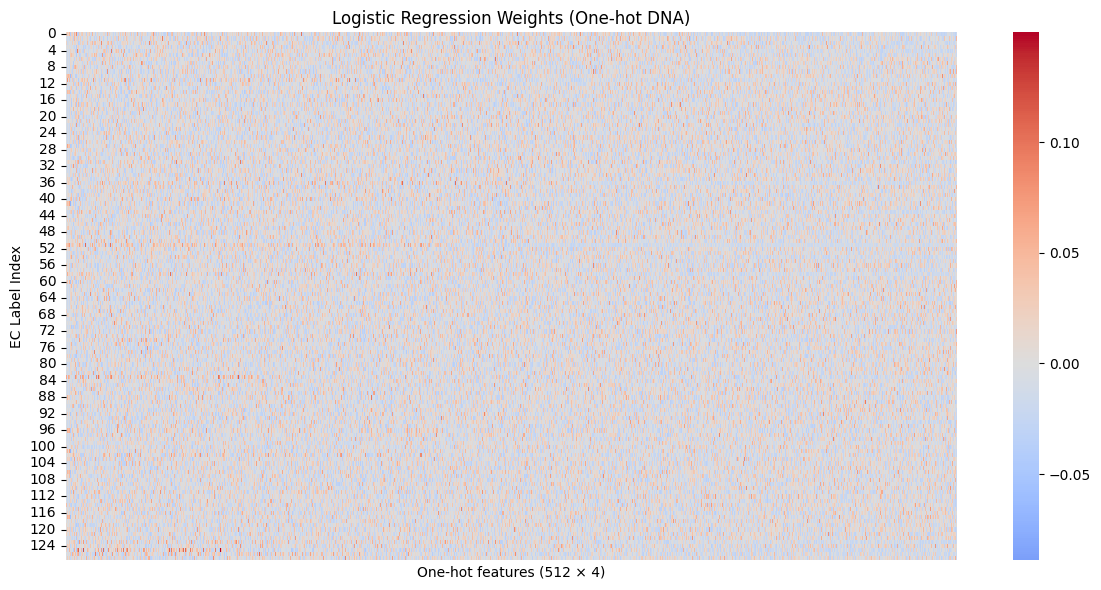

In [22]:
# visualize model coefficients
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize coefficient heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(clf.coef_, cmap="coolwarm", center=0, xticklabels=False)
plt.xlabel("One-hot features (512 × 4)")
plt.ylabel("EC Label Index")
plt.title("Logistic Regression Weights (One-hot DNA)")
plt.tight_layout()
plt.show()


## K-mer Count Feature Variant (e.g., 4-mers)


In [23]:
from collections import Counter
from itertools import product

# Vocabulary of all 4-mers
k = 4
kmer_vocab = [''.join(p) for p in product("ACGT", repeat=k)]

def kmer_features_dna(seq, k=4):
    kmers = [seq[i:i+k] for i in range(len(seq)-k+1)]
    counts = Counter(kmers)
    return np.array([counts.get(kmer, 0) for kmer in kmer_vocab])

In [24]:
X_train_kmer = np.stack(df_train["Sequence"].map(kmer_features_dna))
X_test_kmer = np.stack(df_test["Sequence"].map(kmer_features_dna))

print("Shape of k-mer feature matrix:", X_train_kmer.shape)


Shape of k-mer feature matrix: (640, 256)


In [ ]:
#retrain log reg
clf_kmer = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    max_iter=1000,
    n_jobs=-1,
    verbose=1
)
clf_kmer.fit(X_train_kmer, y_train)

y_pred_kmer = clf_kmer.predict(X_test_kmer)
print("K-mer Accuracy:", accuracy_score(y_test, y_pred_kmer))
print("K-mer F1-score (macro):", f1_score(y_test, y_pred_kmer, average='macro'))


In [42]:
print("K-mer Accuracy:", accuracy_score(y_test, y_pred_kmer))
print("K-mer F1-score (macro):", f1_score(y_test, y_pred_kmer, average='macro'))

K-mer Accuracy: 0.75
K-mer F1-score (macro): 0.6854166666666667


## cross val evaluation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    clf,
    X_train,
    y_train,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)



In [43]:
print("5-fold cross-validated F1 scores:", scores)
print("Mean F1:", scores.mean())


5-fold cross-validated F1 scores: [0.05729167 0.02734375 0.04739583 0.03125    0.01484375]
Mean F1: 0.035625


## blast based evaluation

In [33]:
#step 1: write sequences to fasta
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO

# Write training sequences
train_records = [
    SeqRecord(Seq(seq), id=entry, description=label)
    for seq, entry, label in zip(df_train["Sequence"], df_train["Entry"], df_train["Label"])
]
SeqIO.write(train_records, "train_set.fasta", "fasta")

# Write test sequences
test_records = [
    SeqRecord(Seq(seq), id=entry, description=label)
    for seq, entry, label in zip(df_test["Sequence"], df_test["Entry"], df_test["Label"])
]
SeqIO.write(test_records, "test_set.fasta", "fasta")


128

In [37]:
# #run this from terminal and save the blast results.txt 
# #step 2 : create BLAST DB
# !makeblastdb -in train_set.fasta -dbtype nucl -out train_db
# # step 3- run blast
# !blastn -query test_set.fasta -db train_db -outfmt "6 qseqid sseqid pident length" -out blast_results.txt

In [ ]:
## parse blast results and evaluate

In [39]:
df_train[["Entry", "Label"]].to_csv("train_metadata.csv", index=False)
df_test[["Entry", "Label"]].to_csv("test_metadata.csv", index=False)


In [40]:

# Load BLAST results
blast_df = pd.read_csv("blast_results.txt", sep="\t", header=None,
                       names=["query", "subject", "pident", "length", "bitscore"])

# Load EC label mapping
df_train = pd.read_csv("train_metadata.csv")  # Contains Entry and Label
df_test = pd.read_csv("test_metadata.csv")

entry_to_label = dict(zip(df_train["Entry"], df_train["Label"]))
true_labels = dict(zip(df_test["Entry"], df_test["Label"]))

# Predict using top BLAST hit
blast_df["pred_label"] = blast_df["subject"].map(entry_to_label)
blast_df["true_label"] = blast_df["query"].map(true_labels)

# Drop NA (if any query had no match)
blast_df = blast_df.dropna(subset=["pred_label", "true_label"])

from sklearn.metrics import accuracy_score, f1_score

y_true = blast_df["true_label"]
y_pred = blast_df["pred_label"]

print("BLAST Accuracy:", accuracy_score(y_true, y_pred))
print("BLAST Macro F1:", f1_score(y_true, y_pred, average='macro'))



BLAST Accuracy: 0.9932432432432432
BLAST Macro F1: 0.9895833333333333


In [41]:
## check for missing predictions
missed = set(df_test["Entry"]) - set(blast_df["query"])
print(f"{len(missed)} test sequences had no BLAST hits.")


0 test sequences had no BLAST hits.
